<a href="https://colab.research.google.com/github/ruzicve/bakalarka/blob/main/HIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# --- IMPORTS ----
import numpy as np
import matplotlib.pyplot as plt
from imageio.v2 import imread
from numpy.fft import fft2, ifft2, fftshift, ifftshift

# Install required imageio plugin for .png support
!pip install imageio[pyav]

In [25]:
# --- IMAGES IMPORT FOR TESTING ----
import os

# Downloading an image (star.png in this case) from GitHub
!wget -O /content/star.png https://raw.githubusercontent.com/ruzicve/bakalarka/603cf2d69e12014ccce5ccdb78d4ee0f89b72325/star.png

# Set the uploaded_image_name variable to the downloaded file
uploaded_image_name = 'star.png'


--2026-02-25 15:40:31--  https://raw.githubusercontent.com/ruzicve/bakalarka/603cf2d69e12014ccce5ccdb78d4ee0f89b72325/star.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3228 (3.2K) [image/png]
Saving to: ‘/content/star.png’

/content/star.png   100%[===================>]   3.15K  --.-KB/s    in 0s      

2026-02-25 15:40:32 (44.5 MB/s) - ‘/content/star.png’ saved [3228/3228]



In [26]:
# --- NEW AUXILIARY FUNCTIONS ---

def add_gaussian_noise(image, sigma):
    """Adds Gaussian noise to an image array."""
    if sigma <= 0: return image
    noise = np.random.normal(0, sigma, image.shape)
    return image + noise

def scale_dynamic_range(image, target_min=0.0, target_max=1.0):
    """Scales the min-max dynamic range of an image."""
    current_min = np.min(image)
    current_max = np.max(image)
    if current_max == current_min:
        return np.ones_like(image) * target_min
    normalized = (image - current_min) / (current_max - current_min)
    scaled = normalized * (target_max - target_min) + target_min
    return scaled

In [27]:
# --- AUXILIARY FUNCTIONS FROM BEFORE---
def add_buffer(image, buffer_percentage):
    """
    Adds a uniform zero-value buffer around an image.
    The final size is calculated based on the REQUIRED OVERSAMPLING
    relative to the actual NON-ZERO SUPPORT size (bounding box).
    """
    if not 0 < buffer_percentage < 0.5:
        raise ValueError("Buffer percentage must be between 0 and 0.5 (0% to 50%).")

    h_orig, w_orig = image.shape[:2]

    # 1. Find Support Bounding Box (BB) Dimensions
    coords = np.argwhere(image != 0)
    if coords.size == 0:
        print("Warning: Image is empty. No buffer added.")
        return image

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    # Dimensions of the actual object support
    support_h = y_max - y_min + 1
    support_w = x_max - x_min + 1

    # 2. Calculate Final Required Array Size
    support_size_factor = 1.0 - (2 * buffer_percentage)

    # Required size of the array to contain the support plus padding
    h_required = int(np.ceil(support_h / support_size_factor))
    w_required = int(np.ceil(support_w / support_size_factor))

    # 3. Calculate Padding to add to the existing array

    # The final array must be at least the original size, and at least h_required.
    h_final_target = max(h_orig, h_required)
    w_final_target = max(w_orig, w_required)

    total_pad_h = h_final_target - h_orig
    total_pad_w = w_final_target - w_orig

    # Distribute padding evenly around the current image
    pad_top = total_pad_h // 2
    pad_bottom = total_pad_h - pad_top
    pad_left = total_pad_w // 2
    pad_right = total_pad_w - pad_left

    pad_width = ((pad_top, pad_bottom), (pad_left, pad_right))

    # Apply padding
    padded_image = np.pad(
        image,
        pad_width=pad_width,
        mode='constant',
        constant_values=0
    )
    return padded_image

def load_img(path, oversampling=0, shapes=False):
    """Loads image, preprocesses, and applies zero padding if oversampling > 0."""
    img_rgba = imread(path)

    if img_rgba.ndim == 2:
        img_gray = img_rgba.astype(np.float32) / np.max(img_rgba)
        alpha_channel = np.ones_like(img_gray)
    else:
        if img_rgba.shape[2] == 4:
            alpha_channel = img_rgba[:, :, 3] / 255.0
            img_rgb = img_rgba[:, :, :3] / 255.0
        else:
            alpha_channel = np.ones_like(img_rgba[:, :, 0])
            img_rgb = img_rgba[:, :, :3] / 255.0

        img_gray = np.mean(img_rgb, axis=2)

    transparent = (alpha_channel < 0.01)
    img_gray[transparent] = 0.0

    if shapes:
        opaque = (alpha_channel >= 0.01)
        img_gray[opaque] = 1.0

    if oversampling > 0:
        final = add_buffer(img_gray, oversampling)
    else:
        final = img_gray
    return final





In [28]:
# --- HIO
def hio_reconstruct(magnitude_data, support, beta=0.9, max_iterations=500, seed=None):
    """
    Performs the Hybrid Input-Output (HIO) phase retrieval algorithm with fixed support.

    The HIO update rule for pixels outside the support is:
    g_k+1(r) = g_k(r) - beta * f_k(r)

    Args:
        magnitude_data (np.ndarray): The measured diffraction magnitude (|F(k)|).
        support (np.ndarray): Binary mask (1 inside support, 0 outside).
        beta (float): HIO feedback parameter (typically 0.7 to 1.0).
        max_iterations (int): Maximum number of iterations to run.

    Returns:
        np.ndarray: The reconstructed object (real-space image).
        list: List of error metrics (e.g., magnitude error) per iteration.
    """
    if seed is not None:
        np.random.seed(seed)

    # --- Meaning? ---
    # f_k(r) ... real space, loop input
    # f_k[support==0] violations in the support constraint
    # g_k[support==0] previous result we want to modify, same values as f_k[support==0] (the difference is only conceptual)
    # g_k_plus_1(r) ... result after applying support constraint on f_k
    # G_k_plus_1(q) ... FT of g_k_plus_1
    # G_k_plus_1_constained(q) ... Fourier space, after applying magnitude constraint
    # f_k_plus_1_complex(r) ... IFT of previous
    # g_k(r)... loop output, f_k_plus_1 = g_k

    # --- Initialize the guess (g_k) as random phase multiplied by the measured magnitude. ---
    # Shift the magnitude data for the FFT.
    F_mod = fftshift(magnitude_data)

    # Generate random phase [-pi, pi]
    random_phase = np.exp(1j * np.random.uniform(-np.pi, np.pi, F_mod.shape))

    # Initial guess spectrum G_k: F_mod * exp(i * random_phase), constrained by magnitude in the Fourrier space
    G_k = F_mod * random_phase

    # Shift to real space
    # This is actually f_0 (it is saved in the g_k variable to make the first line in the HIO loop valid for k==0)
    g_k = np.real(ifft2(G_k))

    error_metric = []

    print(f"Starting HIO reconstruction for {max_iterations} iterations...")

    # HIO Loop
    for k in range(max_iterations):

        # -------- Real-Space --------
        # g_k is the output from the previous loop (after the Fourier-Space projection, it might violate the Real-Space constraint)
        f_k = g_k

        # Determine the next input for the IFT (g_k+1) based on real-space constraints.
        # Initiate a new array of the correct size
        g_k_plus_1 = np.zeros_like(f_k, dtype=np.float64)

        # --- Support Constraint ---
        # Within the support (support == 1):
        # Keep the current values
        g_k_plus_1[support == 1] = f_k[support == 1]

        # Outside the support (support == 0):
        # Apply the HIO feedback rule
        # f_k[support == 0] are the magnitudes of errors (since the value should be 0)
        # g_k represents the previous result we are now modifying
        # g_k and f_k have the same value at this point
        g_k_plus_1[support == 0] = g_k[support == 0] - beta * f_k[support == 0]

        # ------ Fourier-Space ------
        # Forward Transform: G_k+1 = FT{g_k+1}
        # Note: g_k_plus_1 is a real space image not a centred spectrum, so we do not need ifftshift
        G_k_plus_1 = fft2(g_k_plus_1)

        # Calculate Magnitude Error (for monitoring)
        current_magnitude = np.abs(G_k_plus_1)
        error = np.linalg.norm(current_magnitude - F_mod) / np.linalg.norm(F_mod)
        error_metric.append(error)

        # --- Magnitude Constraint ---
        # Replace the calculated magnitude with the measured magnitude (F_mod),
        # while keeping the calculated phase (G_k_plus_1 / current_magnitude).
        # Prevents zero division if current_magnitude has zero pixels (although it is unlikely in real data).
        G_k_phase = G_k_plus_1 / np.where(current_magnitude > 0, current_magnitude, 1e-12)
        G_k_plus_1_constrained = F_mod * G_k_phase

        # -------- Real Space --------
        # input for the next loop
        f_k_plus_1_complex = ifft2(G_k_plus_1_constrained)

        # The next input guess (g_k) becomes the real part of the IFT output
        # (This is, again, f_k rather than g_k but it completes the cycle: g_k+1 becomes the new input g_k for the next iteration)
        g_k = np.real(f_k_plus_1_complex)

        if k % 50 == 0:
            print(f"Iteration {k}/{max_iterations}: Magnitude Error = {error:.4e}")

    # Final result is the real-space input from the last successful constraint application.
    final_reconstruction = g_k
    return final_reconstruction, error_metric



--- Running HIO Phase Retrieval ---
Starting HIO reconstruction for 1000 iterations...
Iteration 0/1000: Magnitude Error = 8.3937e-01
Iteration 50/1000: Magnitude Error = 2.0651e-02
Iteration 100/1000: Magnitude Error = 1.5706e-02
Iteration 150/1000: Magnitude Error = 1.4832e-02
Iteration 200/1000: Magnitude Error = 1.4546e-02
Iteration 250/1000: Magnitude Error = 1.4506e-02
Iteration 300/1000: Magnitude Error = 1.4051e-02
Iteration 350/1000: Magnitude Error = 1.3991e-02
Iteration 400/1000: Magnitude Error = 1.3910e-02
Iteration 450/1000: Magnitude Error = 1.3882e-02
Iteration 500/1000: Magnitude Error = 1.3871e-02
Iteration 550/1000: Magnitude Error = 1.3741e-02
Iteration 600/1000: Magnitude Error = 1.3678e-02
Iteration 650/1000: Magnitude Error = 1.3677e-02
Iteration 700/1000: Magnitude Error = 1.3677e-02
Iteration 750/1000: Magnitude Error = 1.3677e-02
Iteration 800/1000: Magnitude Error = 1.3677e-02
Iteration 850/1000: Magnitude Error = 1.3677e-02
Iteration 900/1000: Magnitude Erro

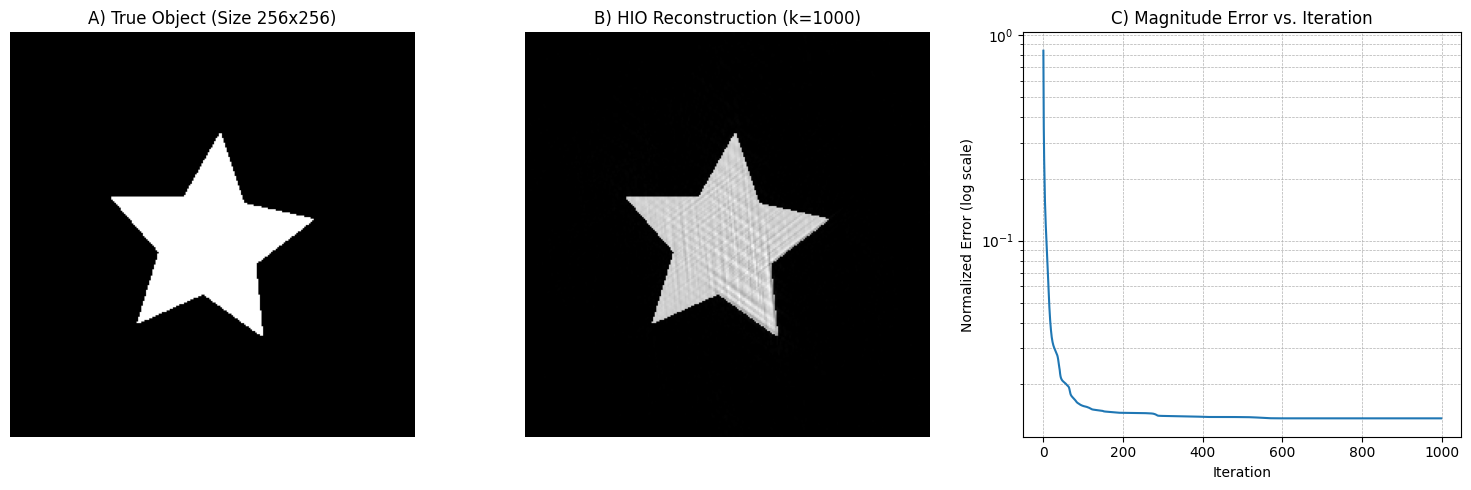

In [29]:
# --- DEMONSTRATION: Load image and run HIO ---
if __name__ == '__main__':

    # Define parameters
    IMAGE_PATH = f'/content/{uploaded_image_name}'
    OVERSAMPLING_PERCENTAGE = 0.25
    BETA = 0.9
    ITERATIONS = 1000
    NOISE_SIGMA = 0.01
    REPRODUCIBILITY_SEED = 42

    # 1. Load and Oversample the Image
    object_true_oversampled = load_img(
        path=IMAGE_PATH,
        oversampling=OVERSAMPLING_PERCENTAGE,
        shapes=True
    )
    NEW_SIZE = object_true_oversampled.shape[0]

    # 2. Create the Oversampled Support Mask
    support_mask_oversampled = (object_true_oversampled > 0)

    # 3. Generate the Measured Diffraction Magnitude (Fourier Constraint)
    F_true = fftshift(fft2(object_true_oversampled))
    measured_magnitude_ideal = np.abs(F_true)

    # Apply Noise to simulate real data
    measured_magnitude = add_gaussian_noise(measured_magnitude_ideal, sigma=NOISE_SIGMA)
    measured_magnitude[measured_magnitude < 0] = 0

    # 4. Run the HIO Algorithm
    print("--- Running HIO Phase Retrieval ---")
    reconstruction, errors = hio_reconstruct(
        magnitude_data=measured_magnitude,
        support=support_mask_oversampled,
        beta=BETA,
        max_iterations=ITERATIONS,
        seed=REPRODUCIBILITY_SEED
    )

    # 5. Display Results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # A) True Object
    axes[0].imshow(object_true_oversampled, cmap='gray')
    axes[0].set_title(f'A) True Object (Size {NEW_SIZE}x{NEW_SIZE})')
    axes[0].axis('off')

    # B) Reconstructed Object
    reconstruction_scaled = scale_dynamic_range(np.abs(reconstruction), 0, 1)
    axes[1].imshow(reconstruction_scaled, cmap='gray')
    axes[1].set_title(f'B) HIO Reconstruction (k={ITERATIONS})')
    axes[1].axis('off')

    # C) Error Plot
    axes[2].semilogy(errors)
    axes[2].set_title('C) Magnitude Error vs. Iteration')
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('Normalized Error (log scale)')
    axes[2].grid(True, which="both", ls="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()